# Modul 06 - Hamiltonian Simulation

Eine Schulungsserie der Meetup-Gruppe **[Quantum Computing meets Business - Rhineland](https://www.meetup.com/de-DE/Quantum-Computing-meets-Business-Rhineland/)**

(Adapted from [qiskit-textbook](https://github.com/qiskit-community/qiskit-textbook))

In [2]:
run ./00-Inhalt_Tools.ipynb

## Inhaltsverzeichnis

0. [Motivation](#motivation)
1. [Ising Modell](#isingmodel)
2. [Schrödinger Gleichung](#schroedinger)
3. [Klassische Lösung](#classicalsolution)
4. [Trotter Approximierung](#trotterization)
5. [Implementierung](#implementation)
6. [Quantum Utility Experiment](#quantumutilityexperiment)
7. [Verweise](#references)

## 0. Motivation

Die Idee für den Bau eines Quantencomputer geht auf Richard Feynman und Paul Benioff zurück. 
Ihre Motivation war es einen Computer zu bauen, der auf den Gesetzen der Quantenmechanik basiert und damit Quantensysteme direkt simulieren.
Auf klassischen Computern ist dies aus vielerlei Gründen nur unzureichend und ineffizient möglich. 
Vereinfacht gesagt haben sie von einem Computer geträumt, der durch seinen Aufbau die Quantenmechanik inherent simulieren kann. 

Nebenbei: In sehr ähnlicher Form wird uns dieses Problem später nochmal beim QAOA-Algorithmus für allgemeine Optimierungsaufgaben begegnen. 
D.h. alles was wir hier lernen, können wir dann nochmal direkt wiederverwenden.

## 1. Das Ising Model <a id="isingmodel"></a>

Magneten sind Materialien mit denen wir schon im Kindesalter spielen und die für uns selbstverständlich sind. 
Aus physikalischer Sicht sind magnetische Materialien jedoch ein komplexes Phänomen, welches erst durch die Entdeckung der Quatenmechanik vollständig erklärt werden konnte. 
Dahingegen ist das Phänomen des Elektromagnetismus weitgehend durch Schulphysik erklärbar. 

Zur Beschreibung von Materialien mit magnetischen Eigenschaften wurden im Laufe der Zeit verschiedene Modelle entwickelt. 
Das Einfachste von ihnen ist das sog. Ising-Modell. Das Ising Modell besteht aus mehreren Spins in einem Gitter. 
Hierbei handelt es sich um quantenmechanische **Elementarmagneten**, welche bei Messung nur zwei mögliche Ausrichtungen besitzen.
Diese Ausrichtungen werden als **Spin-Up** und **Spin-Down** bezeichnet. 
Mathematisch lässt sich ein Spins durch die Pauli-Operatoren $\sigma^{x}, \sigma^{y}, \sigma^{z}$ beschreiben. 
Ein Operator lässt sich in der Regel als große Matrix darstellen. Die Pauli-Operatoren können als Matrix dargestellt werden und entsprechen dann dem X-, Y- und Z-Gatter. 
Untereinander wechselwirken die Spins mit ihren direkten Nachbarn. Zusätzlich unterliegen sie einem externen Magnetfeld, welches die einzelnen Spins beeinflusst. 

Wie alle quantenmechanischen Systeme wird das gesamte Verhalten des Ising-Modells durch seinen Hamilton Operator beschrieben. 
Dieser Operator beschreibt die Energie der Wechselwirkungen der einzelnen Systembestandteile untereinander und mit der Umgebung. 
Falls eine Wechselwirkung des Spins $j$ in einer der drei Komponenten $x, y, z$ stattfindet, so gibt es einen entsprechenden Term im Hamiltonian. 
Für das Ising Modell ergibt sich der Hamiltonian wie folgt: 

$$
H = \sum_{<j,k>} J \sigma^z_j \sigma^z_k + \sum_j h \sigma^x_j.
$$

Hierbei ist $J$ die Stärke der Wechselwirkung zwischen den Spins und $h$ die Stärke des externen Magnetfelds. 
Während die Interaktion der Spins entlang der z-Achse stattfindet, wirkt das externe Magnetfeld entlang der x-Achse.
Die Summe $\sum_{<j,k>}$ bezeichnet die Summation über die nächsten Nachbarn. 
Bei einem eindimensionalen System also linker und rechter Nachbar.
In der folgenden Abbildung sind die Wechselwirkungen und die Spins als Punkte mit Pfeil dargestellt. 

<float>
    <center>
        <img src="../assets/06-HamiltonianSimulation/ising_model.svg" style="width:800px"/>
    </center>
</float>

Als Beispiel wollen wir uns hier ein System aus drei Qubits anschauen. 
Für diese drei Qubits ergibt sich der Hamilton Operator wie folgt:

$$
\begin{align}
H_3 &= J \left(\sigma^z_1 \sigma^z_2 + \sigma^z_2 \sigma^z_3 \right) + h \left(\sigma^x_1 + \sigma^x_2 + \sigma^x_3 \right) \\
&= J \sigma^z_1 \sigma^z_2 + J \sigma^z_2 \sigma^z_3 + h \sigma^x_1 + h \sigma^x_2 + h \sigma^x_3.
\end{align}
$$

## 2. Die Schrödinger Gleichung <a id="schroedinger"></a>

Die Schrödinger Gleichung ist eine der fundamentalsten Gleichungen der Quantenmechanik. 
Sie beschreibt die zeitliche Entwicklung jedes Quantensystems als Differentialgleichung.
Im Allgemeinen hat sie die folgende Form:

$$
H \lvert \psi (t) \rangle = -i  \frac{\partial}{\partial t} \lvert \psi (t) \rangle ,
$$

hierbei beschreibt $\lvert \psi \rangle$ den Zustandsvektor des Systems und $H$ den bereits oben beschriebenen Hamilton Operator des Systems.
Dieser Operator beschreibt das System im Hinblick auf die möglichen Interaktionen mit sich selbst bzw. der Umgebung. 
Falls dieser Operator nicht von der Zeit abhängig ist, lässt sich die Gleichung formal lösen als:

$$
\lvert \psi (t) \rangle = \exp \left( -i t H \right) \lvert \psi (t=0) \rangle .
$$

<p>
    <details>
    <summary> Erinnerung: Matrix Funktionen </summary>
    <p>
        Bei der Betrachtung von Matrizen und Funktionen stellt sich die Frage, ob man Funktionen auch auf Matrizen anwenden kann. 
        Ein Beispiel wäre für eine Matrix $M \in \mathbb{R}^{m \times n}$ die Funktion $\exp\left(M\right)$.
        Da man Matrizen multiplizieren und addieren kann und für quadratische Matrizen auch Potenzen existieren, sind auch Funktionen unter bestimmten Bedingungen anwendbar. 
        Eine der Bedingungen ist, dass die Matrix quadratisch sein muss, also $M \in \mathbb{R}^{n \times n}$ und die Funktion $f$ über eine Taylorreihe darstellbar ist. 
        Dann lässt sich die Funktion der Matrix wie folgt berechnen:
        $$ 
        f\left(M\right) = \sum_{k=0}^{\infty} f^{(k)}(0) \frac{M^k}{k!},
        $$ 
        wobei $f^{(k)}$ die k-te Ableitung beschreibt. 
    </p>
    <p>
        Im Beispiel der Exponentialfunktion angewendet auf die Matrix $\sigma_x = \left(\begin{matrix} 0 & 1\\ 1 & 0 \end{matrix}\right)$ gilt dann:
        $$ 
        \begin{align}
            \exp\left(\sigma_x\right) = \sum_{k=0}^{\infty} \frac{\sigma_x^k}{k!} 
            = \mathbb{1} + \sigma_x + \frac{1}{2} \mathbb{1} + \frac{1}{3} \sigma_x + \dots 
            = \left(\begin{matrix} 1 & e\\ e & 1 \end{matrix}\right).
        \end{align}
        $$
    </p>
    <p>
       Weiterführende Informationen zur Berechnung von Matrix-Exponentialen finden Sie im Anhang im Kapitel [99-3-LineareAlgebra](../content/99-3-LineareAlgebra.ipynb).
    </details>
</p>
 
Kennt man also den Anfangszustand eines Systems und den Hamilton-Operator lässt sich der Zustand des Systems zu jeder beliebigen Zeit durch die obige Gleichung berechnen. 
In der Praxis steht man jedoch meist vor dem Problem, dass die Gleichung nicht direkt berechenbar ist. 
An dieser Stelle wollen wir nun den Quantencomputer nutzen, um die Gleichung zu berechnen. 
Die grundsätzliche Idee ist wie folgt: Zunächst nutzen einen Quantenschaltkreis, um den Zustand zum Zeitpunkt null also den Anfangszustand zu erstellen. 
Dann erstellen wir einen Schaltkreis, welcher die zeitliche Entwicklung des Systems beschreibt und messen schlussendlich den Endzustand. 
Hierbei steht jedes Qubit für einen Spin. Aus der Messung des Endzustands können wir diesen Rekonstruieren und haben das System damit simuliert. 

## 3. Klassische Lösung <a id="classicalsolution"></a>

Bevor wir nun in die Implementierung mit Qiskit einsteigen, wollen wir uns die Lösung des Problems mit klassischen Mitteln anschauen.
Dazu müssen wir zunächst den Hamilton Operator als Matrix darstellen und können dann dessen Matrix-Exponential berechnen.
Im Anschluss können wir dann den zu betrachtenden Anfangszustand definieren und uns dessen zeitliche Entwicklung anschauen. 
Aus Gründen der Einfachheit wollen wir ein System aus drei Spins mit dem Anfangszustand 100 simulieren. Die Kodierung der Anfangszustands bedeutet, dass der erste Spin im Spin-down Zustand und die anderen um Spin-up Zustand sind. 

Qiskit bietet auch hierfür entsprechende Methoden, um die klassische Berechnung mit Operatoren durchzuführen.
Im Hintergrund werden diese Operatoren als Matrizen dargestellt und die Tensorprodukte ausgerechnet. 
Die einzelnen Operatoren befinden sich im Modul **qiskit.opflow**, zwischen Ihnen lassen sich dann die typischen Operationen ausführen. 
Weitere Informationen findet man in der Dokumentation zu Qiskit [https://qiskit.org/documentation/apidoc/opflow.html](https://qiskit.org/documentation/apidoc/opflow.html). 

In [3]:
from math import pi
from qiskit.opflow import Zero, One, I, X, Y, Z

In [4]:
def H_ising_3(J=2, h=-1):
    # zz interactions
    H_zz = sum([
        Z^Z^I,
        I^Z^Z,
    ])
    
    # x interactions
    H_x = sum([
        X^I^I,
        I^X^I,
        I^I^X,
    ])

    # Return Hamiltonian
    return J * H_zz + h * H_x

In [5]:
time = pi
state_100 = One^Zero^Zero
hamiltonian = H_ising_3(J=2, h=-1)

prob_100_100 = abs((~state_100 @ (time * hamiltonian).exp_i() @ state_100).eval())
print("Die Wahrscheinlichkeit für den Zustand 100 beträgt: ", prob_100_100)

Die Wahrscheinlichkeit für den Zustand 100 beträgt:  0.6937545297026142


Dies bedeutet, dass wir das System simuliert haben und kennen nun die Wahrscheinlichkeit das System nach der Zeit $\pi$ im Zustand 100 vorzufinden. 
Im nächsten Schritt wollen wir das System nun auf dem Quantencomputer simulieren. 
Dazu müssen wir Quantenschaltkreise entwickeln, die zunächst den Anfangszustand erstellen und dann die Zeitentwicklung vornehmen. 

### 3.1 Kurzübung: <a id="ex1"></a>

1. Erstellen Sie ein Ising Modell mit vier Qubits als Kette.
2. Berechnen Sie die Wahrscheinlichkeit das System nach einer Zeit $\pi/2$ im Zustand $\lvert 1000 \rangle$ zu finden bei einem Anfangszustand von $\lvert 0001\rangle$. 

## 4. Die Trotter Approximierung <a id="trotterization"></a>

Während sich der Quantenschaltkreis für den Anfangszustand meist leicht erstellen lässt, ist der Schaltkreis für die zeitliche Entwicklung komplexer.
Daher wollen wir zunächst dem mathematischen Objekt den Namen Zeitentwicklungsoperator $U_t$ geben:

$$
U_t = \exp \left( -i t \hat{H} \right).
$$

Da wir den Operator nicht direkt als Schaltkreis implementieren können, müssen wir einige Vereinfachungen vornehmen. 
Aus der Mathematik wissen wir, dass wir bei Vereinfachungen meistens Fehler machen, deren Größe von der relevanten Skala, hier die Zeit $t$, bestimmt wird. 
Ein einfacher Trick, um die Zeitschritte zu verkleinern ist den Zeitentwicklungsoperator mehrfach hintereinander für kurze Zeiten anzuwenden:

$$ 
U_t = U_{t'} \times U_{t'} \times \dots \times U_{t'} = \prod_{i=1}^{R} U_{t' = t/R}, 
$$

wobei das Zeichen $\prod$ das Pendent zu $\sum$ für Produkte ist. 
Diesen neuen Operator $U_{t'}$ können wir nun weiter vereinfachen.
Dazu schreiben wir uns diesen zunächst für das Ising Modell auf:

$$
U_{t'} = \exp\left( -i t' \left(\sum_{j=1}^{N-1} J \sigma^z_j \sigma^z_{j+1} + \sum_{j=1}^{N} h \sigma^x_j \right)\right). 
$$

<p>
    <details>
    <summary> Erinnerung: Kommutatoren, Potenzen und Matrix Exponentiale </summary>
    <p>
        Während skalare meistens kommutativ sind, also $a b = b a$, gilt dies für Matrizen nicht unbedingt. 
        Dies erkennt man bereits für sehr kleine Matrizen sehr leicht. 
        Um den Unterschied der beiden möglichen Kombinationen zu bestimmen, wurde der sog. Kommutator erfunden:
        $$
            \left[A, B\right] = AB - BA. 
        $$
    </p>
    <p>
        Insbesondere bei der Berechnung von Potenzen von Summen von Matrizen spielt der Kommutator eine besondere Rolle.  
        $$
        \begin{align}
            (A + B)^2 & = (A^2 + AB + BA + B^2) = A^2 + 2AB - [A, B] + B^2. 
        \end{align}
        $$
    </p>
    <p>
        Übertragen auf Expontialfunktionen bedeutet dies, dass für zwei Matrizen gilt:
        $$
            \exp\left(A+B\right) = \exp(A) \exp(B) + \mathcal{O}\left([A, B]\right).
        $$
        Hierbei ist $\mathcal{O}$ eine Bezeichnung für "in der Ordnung von". 
    </details>
</p>

Wir können diesen Operator nun in zwei Teile teilen, zum einen den Teil mit der Interaktion von Qubits $H_{zz}$ und zum anderen den Teil mit der Wirkung der Magnetfelds $H_x$. 
Als erste Vereinfachung wollen wir nun die Exponentialfunktion aufteilen, damit ergeben sich dann zwei Operatoren, die wir einzeln genauer anschauen können:

$$
U_{t'} = \exp\left( -i t' \left( H_{zz} + H_{x} \right)\right) \approx \exp\left( -i t' H_{zz} \right) \exp\left( -i t' H_{x} \right).
$$

Nun wollen wir uns zunächst den letzten der beiden Operatoren anschauen. 
Da der Operator $\sigma^x_j$ nur einzelne Spins bzw. Qubits beeinflusst, lässt sich die Exponentialfunktion einfach auseinander ziehen:

$$ 
\exp\left( -i t' H_{x} \right) = \exp\left( -i t' \sum_{j=1}^{N} h \sigma^x_j \right) = \prod_{j=1}^{N} \exp\left( -i t' h \sigma^x_j \right). 
$$

Aus der Mathematik wissen wir nun, dass es sich bei dem Operator $\exp\left( -i t' h \sigma^x_j \right)$ um eine Drehung um die x-Achse mit dem Winkel $\theta = t' * h$ handelt.
Diese können wir sehr einfach als $R_x\left(\theta\right)$-Gatter implementieren. 

Der andere Operator erfordert komplexere Umformungen.
Da hier das Produkt zweier Spin bzw. Qubit-Operatoren vorkommt, ist ein einfaches auseinanderziehen eigentlich nicht möglich. 
Aus mathematischer Sicht liegt dies an der fehlenden Kommutativität der Operatoren $\left[ \sigma^z_1 \sigma^z_2, \sigma^z_2 \sigma^z_3 \right] \neq 0$. 
Da wir diesen Schritt jedoch trotzdem durchühren wollen, wird ein Fehler in der Größenordnung dieses sog. Kommutators entstehen. 
In erster Näherung wird dieser Fehler proportional zum Quadrat der Zeitschritte $t'$, der Kopplungskonstaten $J$ und dem Kommutator sein.

$$
\exp\left( -i t' H_{zz} \right) = \exp\left( -i t' \sum_{j=1}^{N-1} J \sigma^z_j \sigma^z_{j+1} \right) \approx \prod_{j=1}^{N-1} \exp\left( -i t' J \sigma^z_j \sigma^z_{j+1} \right)
$$

Falls wir den Fehler in diesem Schritt verkleinern wollen, können wir einerseits die Zeitskala $t'$ verkleinern oder eine Formel höherer Ordnung (siehe auch Suzuki-Trotter Formeln [2]) verwenden. Dieser Operator sieht dem $R_z$-Gatter sehr ähnlich.
Entsprechend wird es auch als $R_{zz}$-Gatter bezeichnet. 
Dieses Gatter lässt sich direkt in Qiskit implementieren und wir werden dann sehen, wie es weiter zerlegt werden kann. 

## 5. Implementierung <a id="implementation"></a>

Nach so viel Mathematik und Rechnungen, wollen wir uns nun ein Beispiel anschauen. Dazu wählen wir ein System mit drei Qubits aus und wollen die zeitliche Entwicklung des Anfangszustands $\lvert 100\rangle$ nach der Zeit $t=\pi$ berrechnen. Dazu müssen wir zunächst die benötigten Module von Qiskit importieren.

In [6]:
from qiskit import transpile, execute, QuantumCircuit
from qiskit.providers.aer import AerSimulator

**Grundzustand**

Wie auch oben implementieren wir hier den Grundzustand $\lvert 100\rangle$ indem wir das entsprechende Qubit flippen. 

In [28]:
def groundstate():
    circuit = QuantumCircuit(3)
    circuit.x(2)
    circuit.barrier()
    return circuit

**Trotter Gatter**



In [60]:
def trotter_1(t=pi, J=2, h=-1):
    circuit = QuantumCircuit(3)
    circuit.rzz(2 * J * t, 0, 1)
    circuit.rzz(2 * J * t, 1, 2)
    circuit.barrier()
    circuit.rx(2 * h * t, 0)
    circuit.rx(2 * h * t, 1)
    circuit.rx(2 * h * t, 2)
    circuit.barrier()
    return circuit

**Zeitentwicklung**

In [61]:
def time_evolution(t=pi, N=4):
    circuit = QuantumCircuit(3)
    for k in range(N):
        trotter_1_tJh = trotter_1(t / N, J=2, h=-1)
        circuit.append(trotter_1_tJh, [0, 1, 2])
    return circuit.decompose()

**Simulation**

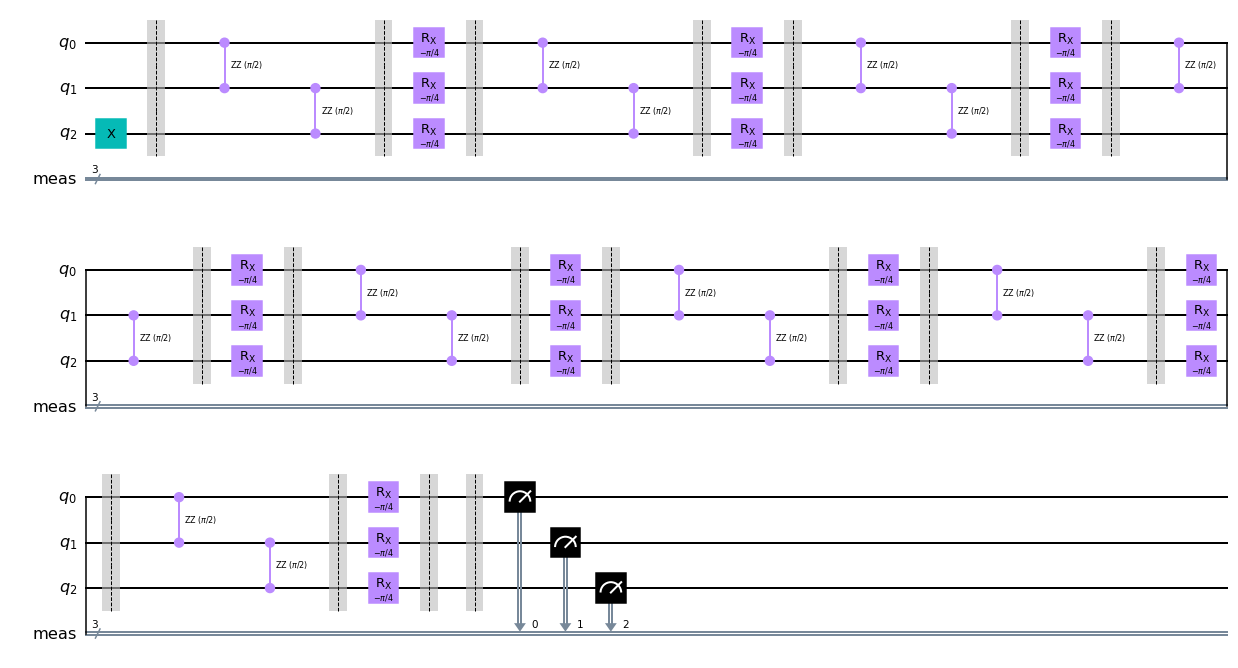

In [62]:
t = pi
N = 8

circuit = QuantumCircuit(3)

circuit.append(groundstate(), [0, 1, 2])
circuit.append(time_evolution(t, N), [0, 1, 2])

circuit.measure_all()

circuit = circuit.decompose()

circuit.draw("mpl")

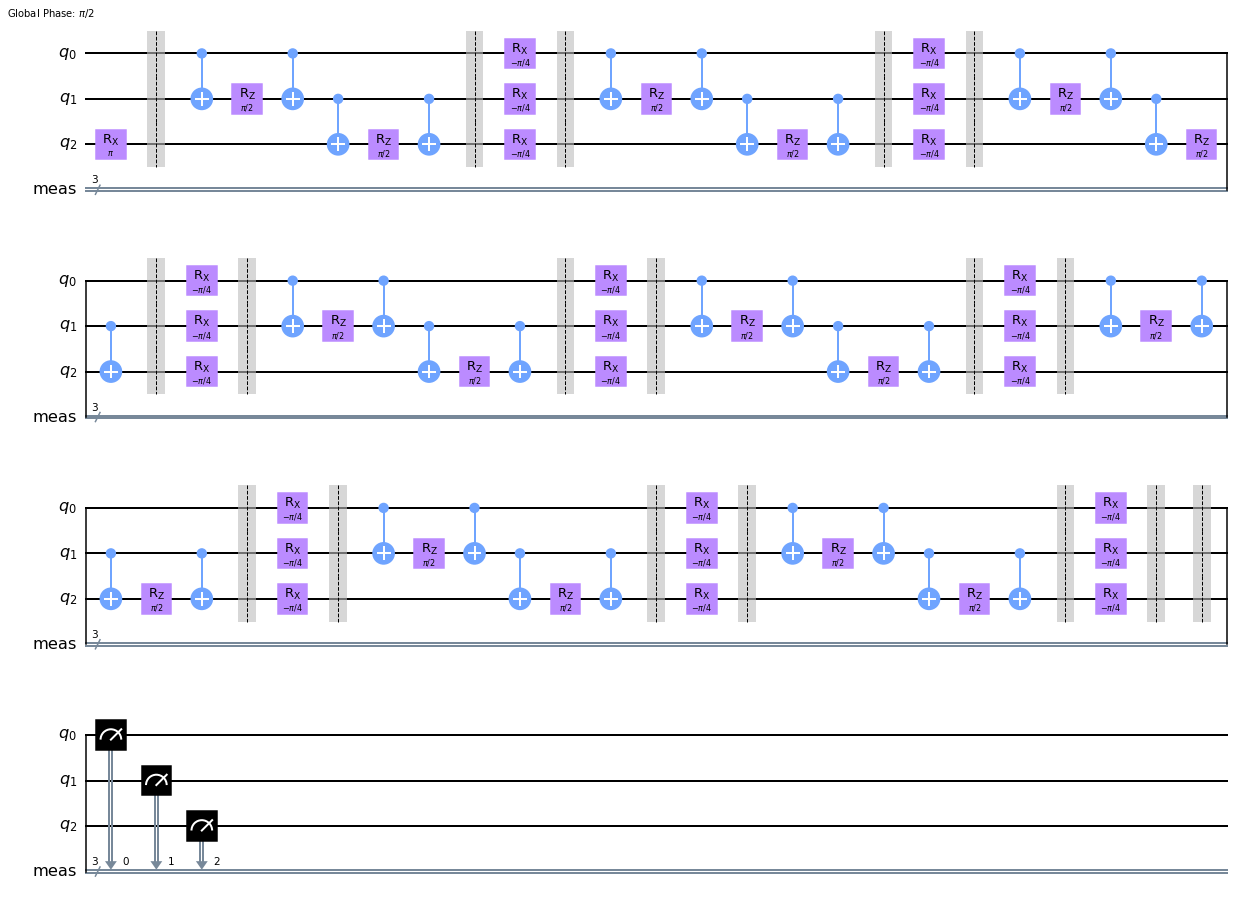

In [63]:
circuit_t = transpile(circuit, basis_gates=["rx", "ry", "rz", "cx"])
circuit_t.draw("mpl")

In [64]:
backend = AerSimulator()
job = execute(circuit_t, backend)

result = job.result()
counts = result.get_counts()
prob_100_100 = counts.get("100", 0) / counts.shots()

print("Die Wahrscheinlichkeit für den Zustand 100 beträgt: ", prob_100_100)

Die Wahrscheinlichkeit für den Zustand 100 beträgt:  0.513671875


### 5.1 Kurzübung: <a id="ex2"></a>

1. Implementieren Sie den entsprechenden Qiskit Code für das Modell aus Übung 1. 

# 6. IBM Quantum Utility Experiment <a id="quantumutilityexperiment"></a>

Im Juni 2023 haben Forscher von IBM ein neues Paper (siehe [Ref. 3](https://www.nature.com/articles/s41586-023-06096-3)) vorgestellt, welches sich mit der Simulation eines Quantensystems beschäftigt in einem Bereich der für klassische Verfahren zunächst unerreichbar schien. Hierfür wurde ein sehr großes Ising-Modell von 127 Qubits simuliert und die Magnetisierung als Observable bestimmt. Dieses Experiment beschreibt damit erstmals eine Rechnung mit prinzipiell ökonomisch relevanter Fragestellung, da das Ising-Modell als Ausgangsmodel für viele weitere relevante Fragestellungen dient. 
Allerdings wurden bereits wenige Tage später neue klassische Algorithmen (siehe bspw. [Ref. 4](https://arxiv.org/abs/2306.14887)) gefunden, die ähnliche Ergebnisse ermöglichen. Wir wollen uns nun im Folgenden das Experiment und die verwendeten Techniken genauer anschauen, um einen ersten Eindruck zu gewinnen. Natürlich können wir hier nicht alle Aspekte des Experiments besprechen, dafür empfehlen wir direkt die Lektüre des [IBM-Research-Blogs](https://research.ibm.com/blog/utility-toward-useful-quantum). 

## 6.1. IBM Eagle Chip

Entgegen der meisten anderen Betrachtungen wollen wir hier mit dem Chip beginnen. Der IBM Quantum Prozessor Architektur der Generation Eagle r3 besteht aus 127 Qubits, welche über eine sog. Heavy-Hexogonal-Topologie miteinander verbunden sind. Explizit wurde im Experiment das Gerät "ibm_kyiv" verwendet, welches im Folgenden zu sehen ist. 

<float>
    <center>
        <img src="../assets/06-HamiltonianSimulation/ibm_kyiv_layout.svg" style="width:400px"/>
        <figcaption>
            IBM Kyiv, 127 Qubit, Eagle r3, IBM Quantum
        </figcaption>
    </center>
</float>

## 6.2. Simulation

### 6.2.1. Ising Simulation

Im vorherigen Abschnitt haben wir bereits das Ising-Modell als ein grundlegendes Modell der Physik kennengelernt. Aufgrund seiner einfachen Struktur wurde es auch innerhalb des Quantum Utility Experiments verwendet. Als eine Vereinfachung wurde kein allgemeines Ising-Modell simuliert, sondern direkt das Layout des Quantencomputers für das Layout des Ising-Modells verwendet. Entsprechend gibt es in dem Spin-Modell nur Interaktionen von Spins, falls diese auch auf dem Gerät verbunden sind. 

<float>
    <center>
        <img src="../assets/06-HamiltonianSimulation/ibm_utility_layout.png" style="width:400px"/>
        <figcaption>
            IBM Quantum
        </figcaption>
    </center>
</float>

Der Schaltkreis lässt sich analog zu unserem Schaltkreis in Ein-Qubit-Rotationen und Zwei-Qubit-Rotationen zerlegen. Die Ein-Qubit-Rotationen bestehen aus $R_x$-Gattern, welche auf jedes einzelne Qubit angewendet werden. Die Zwei-Qubit-Operationen lassen sich in gewissem Maße parallelisieren, d.h. ein Farbschema kann eingeführt werden, welches parallel ausführbare Gatter aufzeigt. Aufgrund der Architektur können die Interaktionen in drei Blöcke mit jeweils $ZZ$-Gattern aufgeteilt werden. Das Bild oberhalb zeigt die Aufteilung der Gatter und Einfärbung der Verbindungen. 

### 6.2.2. Error Mitigation

Aufgrund der Größe des Schaltkreises spielen Fehlerprozesse eine große Rolle. Um den Einfluss der Fehlerprozesse handhabbar zu machen bzw. zu minimieren wurden sog. Fehler-Mitigation-Methoden entwickelt. Diese ermöglichen es auch ohne vollständige Fehlerkorrektur einen Teil der Fehler zu unterdrücken bzw. durch mathematische Methoden herauszurechnen. 
Ein Ansatz ist die kontrollierte und kontinuierliche Veränderung der Fehlerprozesse. Dieses zunächst kontraintuitive Verfahren ermöglicht es zu einem Zustand ohne Fehlerprozesse zu extrapolieren. Grundsätzlich sind Zwei-Qubit-Gatter fehleranfälliger, als entsprechende Ein-Qubit-Gatter, daher wurden auch hier zusätzliche Gatter verwendet, um deren Fehleranfälligkeit zu erhöhen. Die Chararkteristik der verwendeten, zusätzlichen Gatter wurde zuvor im Rahmen von Charakterisierungsexperimenten bestimmt, um eine Vorhersage über deren Einfluss treffen zu können. Damit lassen sich dann entweder Fehler auslöschen (Probabilistic Error Cancellation - PEC) oder verstärken (Zero Noise Extrapolation - ZNE). 

## 6.4. Ergebnisse

Zum Vergleich der Berechnungen auf dem Quantencomputer wurden ebenso aufwändige klassische numerische Simulationen durchgeführt. Hier wurden zwei verschiedene Arten von Verfahren verwendet. Zum Einen exakte Verfahren, die jedoch in ihrer Größe limitiert sind und zum Anderen approximative Verfahren mit wesentlich erweiterter Systemgröße, allerdings unklarer Aussage über ihre Genauigkeit im Parameterbereich. Im Bereich kleiner Simulationen, also nur mit einem Teil der 127 Qubits, zeigen die exakten Verfahren und der Quantencomputer für unterschiedliche Observable die gleichen Werte. Am Rande des Parameterbereichs versagen die approximativen, klassischen Verfahren allerdings bereits früh.

<float>
    <center>
        <img src="../assets/06-HamiltonianSimulation/ibm_utility_results_small.png" style="width:800px"/>
        <figcaption>
            IBM Quantum
        </figcaption>
    </center>
</float>

Für größere Systeme versagen die klassischen Algorithmen ebenfalls, allerdings bietet der Quantencomputer gute Werte. Die Ergebnisse lassen sich in den folgenden Bildern sehen.

<float>
    <center>
        <img src="../assets/06-HamiltonianSimulation/ibm_utility_results_large.png" style="width:800px"/>
        <figcaption>
            IBM Quantum
        </figcaption>
    </center>
</float>

Allerdings wurden nur wenige Tage nach der Veröffentlichung der Ergebnisse neue näherungsweise, klassische Verfahren gezeigt. Diese können das Ising-Modell auch für große Systemgrößen simulieren und zeigen die gleichen Ergebnisse, wie der Quantencomputer. Sie basieren auf neuen Ansätzen der Tensor-Netzwerke. 

## 6.5. Zusammenfassung

Die Ergebnisse der Berechnung lassen sich unterschiedlich einschätzen. Zum Einen ist eine Berechnung dieser Größe etwas vollkommen neues und zeigt das Potential dieser Technologie auf. Zum Anderen wurden auch recht schnell neue klassische Methoden gefunden, die ähnliche Ergebnisse erreichen. Dieses hin-und-her von klassischen und quantenbasierten Verfahren werden wir in naher Zukunft wahrscheinlich noch mehrfach beobachten. Es zeigt allerdings, wie die Technologie Quantencomputing immer weiter voranschreitet und dabei immer stärker in Bereiche vordringt, wo sie eine ernsthafte Alternative zu klassischen Verfahren darstellt. 

## 7. Verweise <a id="references"></a>

1. R. Feynman, Simulating Physics with Computers, 1982, [https://link.springer.com/article/10.1007/BF02650179](https://link.springer.com/article/10.1007/BF02650179)
2. M. Suzuki, N. Hatano, Finding Expontial Product Formulas for Higher Orders, 2005, [https://arxiv.org/abs/math-ph/0506007v1](https://arxiv.org/abs/math-ph/0506007v1)
3. Y. Kim, A. Eddings, S. Anand, K.X. Wei, E. van den Berg, S. Rosenblatt, H. Nayfeh, Y. Wu, M. Zaletel, K. Temme, A. Kandala, Evidence for the utility of quantum computing before fault tolerance [https://www.nature.com/articles/s41586-023-06096-3](https://www.nature.com/articles/s41586-023-06096-3)
4. J. Tindall, M. Fishman, M. Soudenmire, D. Sels, Efficient tensor network simulation of IBM's kicked Ising experiment [https://arxiv.org/abs/2306.14887](https://arxiv.org/abs/2306.14887)

## Qiskit

In [1]:
import qiskit
qiskit.__qiskit_version__

/opt/miniforge3/envs/qcmb-training/lib/python3.8/site-packages/qiskit/version.py:119: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit import ignis
/opt/miniforge3/envs/qcmb-training/lib/python3.8/site-packages/qiskit/version.py:162: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  self._load_versions()


{'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.0', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

## Copyright

Copyright 2021 Dual Software GmbH and SVA System Vertrieb Alexander GmbH

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.